# Double Pendulum Example
In this example, we: 
- Generate some data from a double pendulum, 
- Observe its joint angles with some noise,
- Use Kalman smoothing to recover a timeseries of smoothed joint angles, and,
- Fit a Structured Mechanical Model to the data by minimizing the DEL-residual.

In [1]:
# change dir so that delsmm is the root dir
import os
os.chdir('..')

# Imports

In [2]:
%load_ext autoreload
%autoreload 2

# import for visualization
from delsmm.plotutils.dpen_viz import dpen_viz
import matplotlib.pyplot as plt

# imports for simulation
import torch
from ceem import utils
from delsmm.systems.lag_doublepen import LagrangianDoublePendulum
from tqdm import tqdm
import numpy as np

# imports for smoothing
from delsmm.utils import kalman_smooth_and_diff

# imports for fitting
from delsmm.smm import StructuredMechanicalModel
from delsmm.barriercrit import LogDetBarrierCriterion
from delsmm.lagcrit import DELCriterion
from ceem.opt_criteria import GroupCriterion

from torch.utils.data import TensorDataset, DataLoader

from torch.nn.utils import parameters_to_vector as ptv
from torch.nn.utils import vector_to_parameters as vtp

# Simulating the Double Pendulum System
In this section, we simulate the double pendulum system. We use variational integration to integrate the system, which is inherits the `delsmm.smm.BasicLagrangianSystem` class.

In [3]:
utils.set_rng_seed(2)

torch.set_default_dtype(torch.float64)

# define system
dt = 0.05
qdim = 2
sys = LagrangianDoublePendulum(dt, 1.,1.,1.,1.,10.)

# specify some initial conditions
q1 = torch.rand(1,1,2) * np.pi - np.pi/2
q2 = q1.clone()

qs = [q1, q2]

# simulate
for t in range(200):
    qt = qs[-2].detach()
    qtp1 = qs[-1].detach()

    nq = sys.variational_step(qt,qtp1)
    qs.append(nq)

q = torch.cat(qs, dim=1).detach()

# add some noise
qpert = q + torch.randn_like(q) * 0.01

# define the timeseries
B, T, _ = q.shape
t = torch.arange(T).unsqueeze(0).repeat(B,1).float() * dt

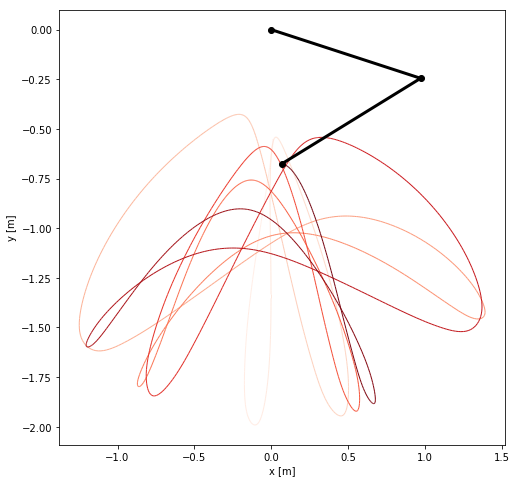

In [4]:
# visualize the trajectory

plt.figure(figsize=(8,8))
ax = plt.gca()

dpen_viz(ax,q,1.,1.)

plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.show()

# Smooth the noisy observations of q using Kalman smoothing

In [ ]:
smq, smdq, smddq = kalman_smooth_and_diff(qpert,dt)

100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


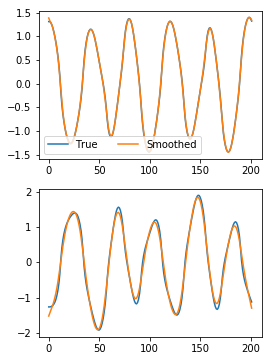

In [ ]:
# plot the true and smoothed timeseries
plt.figure(figsize=(4,6))
plt.subplot(2,1,1)
plt.plot(q[0,:,0], label = 'True')
plt.plot(smq[0,:,0], label = 'Smoothed')
plt.legend(ncol=2, loc='lower left')

plt.subplot(2,1,2)
plt.plot(q[0,:,1])
plt.plot(smq[0,:,1])

plt.show()

As we can see, the smoothed states don't perfectly match the true states.

# Fit an SMM to the smoothed data by minimizing the DEL residual

In [ ]:
# create the dataloader
smq_1 = smq[:,:-2]
smq_2 = smq[:,1:-1]
smq_3 = smq[:,2:]
smq_B = torch.stack([smq_1,smq_2,smq_3], dim=2).reshape(-1,3,2).detach()
dataset = TensorDataset(smq_B)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# initialize the SMM
torch.manual_seed(1)
system = StructuredMechanicalModel(qdim=qdim, dt=dt)

# now, we set up the criterion which we minimize to fit the model
# the criterion is a combination of DELCriterion, which computes the DEL-residual, and a LogDetBarrierCriterion
# which computes the regularization term.
dyncrit = DELCriterion(t)

# initialize the barrier criterion, and find an appropriate coefficient between it and the DELCriterion
lb = LogDetBarrierCriterion.mineig(system, smq).detach() * 0.99 # interior point init

barriercrit = LogDetBarrierCriterion(lb)

# find an appropriate mu
with torch.no_grad():
    dyncritloss = dyncrit(system, smq)
    barriercritloss = barriercrit(system, smq)

    mu = float(dyncritloss / barriercritloss) # mu makes them ~equal at init

barriercrit = LogDetBarrierCriterion(lb, mu=mu, x_override=smq)

crit = GroupCriterion([dyncrit, barriercrit]) # this groups the criteria into one

# Set up the optimizer and scheduler
opt = torch.optim.Adam(system.parameters(), lr = 1e-2)
sched = torch.optim.lr_scheduler.LambdaLR(opt, lambda k: 50./(50+k))

# intialize `next_params`, which is used in case we need to line-search.
next_params = ptv(system.parameters()).detach()

## Train the SMM using SGD

In [ ]:
for epoch in range(500):

    for batch in dataloader:

        prev_params = next_params

        opt.zero_grad()

        loss = crit(system, *batch)

        loss.backward()

        opt.step()

        # check line search in case the we stepped out of the LogDetBarrierCriterion's domain.
        n_ls  = 0
        while True:

            next_params = ptv(system.parameters()).detach()

            del_params = next_params - prev_params

            with torch.no_grad():
                c = crit(system, smq)

            if torch.isnan(c):
                next_params = prev_params + 0.5 * del_params
                vtp(next_params, system.parameters())

                n_ls += 1
            else:
                break
    
    sched.step()
    
    # print progress
    if epoch % 100 == 0:
        print('Epoch %d, Loss %.3e' % (epoch, float(loss)))


Epoch 0, Loss 1.339e+04
Epoch 100, Loss -5.760e+05
Epoch 200, Loss -5.874e+05


# Simulate the learned system

In [ ]:
# First, convert q_1, q_2 into q, qdot
q1 = q[:,0:1]
q2 = q[:,1:2]

q_ = 0.5 * (q1+q2)
qdot = (q2-q1)/dt

x = torch.cat([q_,qdot],dim=-1)

# now simulate
xs = [x]
with torch.no_grad():
    for t in tqdm(range(T+1)):
        xs.append(system.step(torch.zeros(1,1).float(), xs[-1]))

xs = torch.cat(xs, dim=1)
qsim = xs[...,:qdim].detach()

In [ ]:
# visualize the simulation of the learned system

plt.figure(figsize=(8,8))
ax = plt.gca()

dpen_viz(ax,qsim,1.,1.)

plt.show()

Of course, the learned system's simulations don't exactly match the true system, because the system is chaotic and we're fitting to smoothed data. However, we see the rough double-pendulum behavior is recovered!